## k-means clustering for taxi dataset (hopefully now neater/more organized than the original one used for uber )

In [2]:
import csv
import pandas as pd
import networkx as nx
import random
import math
import numpy as np
import matplotlib.pyplot as plt
from scipy.cluster.vq import kmeans2, whiten
from sklearn.cluster import KMeans
import geopy
import zipcodes
from time import sleep
from statistics import mean
from geopy.extra.rate_limiter import RateLimiter
from mpl_toolkits.basemap import Basemap
from sodapy import Socrata

In [4]:
# Unauthenticated client only works with public data sets. Note 'None'
# in place of application token, and no username or password:
client = Socrata("data.cityofnewyork.us", None)

# First 2000 results, returned as JSON from API / converted to Python list of
# dictionaries by sodapy.
results = client.get("gkne-dk5s", where="pickup_datetime between '2014-04-01T00:00:00' and '2014-04-30T23:59:59'", limit=1000000)

# Convert to pandas DataFrame
data_taxi = pd.DataFrame.from_records(results)

In [60]:
# access coordinate data 
lat = data_taxi['pickup_latitude']
lon = data_taxi['pickup_longitude']
shapefiles ={}
shapefiles['shapes/ZIP_CODE_N'] = 'zipcodes'
data_taxi

,dropoff_datetime,dropoff_latitude,dropoff_longitude,fare_amount,imp_surcharge,mta_tax,passenger_count,payment_type,pickup_datetime,pickup_latitude,pickup_longitude,rate_code,store_and_fwd_flag,tip_amount,tolls_amount,total_amount,trip_distance,vendor_id
0,2014-04-06T10:08:16.000,40.703707000000001,-74.014576000000005,17.5,0,0.5,3,CSH,2014-04-06T09:50:47.000,40.758262999999999,-73.992018000000002,1,N,0,0,18,4.7999999999999998,CMT
1,2014-04-04T09:37:52.000,40.750933000000003,-74.004014999999995,7,0,0.5,1,CRD,2014-04-04T09:30:03.000,40.750328000000003,-73.994533000000004,1,N,1.5,0,9,0.80000000000000004,CMT
2,2014-04-20T13:04:17.000,40.737774999999999,-73.989807999999996,5,0,0.5,2,CSH,2014-04-20T12:59:51.000,40.734248000000001,-73.995760000000004,1,N,0,0,5.5,0.69999999999999996,CMT
3,2014-04-18T13:24:16.000,40.773066999999998,-73.964402000000007,14.5,0,0.5,4,CSH,2014-04-18T13:03:53.000,40.747515999999997,-73.985309000000001,1,N,0,0,15,2.6000000000000001,CMT
4,2014-04-10T06:31:00.000,40.721426999999998,-74.009862999999996,11,0,0.5,1,CRD,2014-04-10T06:19:00.000,40.738151999999999,-73.983440000000002,1,NaN,2.2000000000000002,0,13.699999999999999,2.8300000000000001,VTS
5,2014-04-02T19:33:16.000,40.761333999999998,-73.999951999999993,8,1,0.5,1,CRD,2014-04-02T19:24:08.000,40.764594000000002,-73.983129000000005,1,N,1.8999999999999999,0,11.4,1.3,CMT
6,2014-04-26T18:37:54.000,40.742240000000002,-73.995301999999995,22.5,0,0.5,3,CRD,2014-04-26T18:05:14.000,40.710751000000002,-73.953222999999994,1,N,5.75,0,28.75,4.2999999999999998,CMT
7,2014-04-03T19:02:58.000,40.772013999999999,-73.953023000000002,20.5,1,0.5,1,CRD,2014-04-03T18:45:29.000,40.711751999999997,-74.007386999999994,1,N,2.25,0,24.25,6.7000000000000002,CMT
8,2014-04-07T11:43:09.000,40.751778000000002,-73.992859999999993,4.5,0,0.5,1,CRD,2014-04-07T11:40:03.000,40.751809000000002,-73.983300999999997,1,N,1,0,6,0.80000000000000004,CMT
9,2014-04-29T12:55:56.000,40.765357999999999,-73.983417000000003,14.5,0,0.5,1,CSH,2014-04-29T12:31:56.000,40.771051999999997,-73.963721000000007,1,N,0,0,15,1.6000000000000001,CMT


In [9]:
# create DiGraph using k-means clustering
def createDiGraphK(data, sample_size=None, k=40, iters=40, name='ktemp-taxi'):
    # cluster data using k-means
    lat = data.pickup_latitude.astype(float)
    lon = data.pickup_longitude.astype(float)
    coordinates= np.array(list(zip(lat, lon)))
    centroids, labels = kmeans2(whiten(coordinates), k, iter = iters) 
    
    # create graph with k nodes
    G = nx.DiGraph(); 
    if (sample_size is None):
        sample_size = len(data)
    for pick_up in range(sample_size):
        
        # get k-means centroid from src and randomize dest based on uniform distribution among all clusters
        #rand_idx = random.randint(0, len(labels) - 1)
        rand_idx = pick_up
        la = lat[pick_up]
        lo = lon[pick_up]
        src = labels[rand_idx]
        dest = random.randint(0, k - 1)

        # increase edge weight from src -->  dest by 1 
        if not G.has_node(src):
            G.add_node(src, lat=0, lon=0)
        if not G.has_node(dest):
            G.add_node(dest, lat=0, lon=0)
        if not G.has_edge(src, dest):
            G.add_edge(src, dest, weight=0)
        G[src][dest]['weight'] += 1
        G.node[src]['lat'] = (G.node[src]['lat'] +  la) / 2 #keep a running average
        G.node[src]['lon'] =  (G.node[src]['lon'] +  lo) / 2
        
        #print("Adding edge from " + str(src) + " to " + str(dest))
        if (pick_up > 1000 and pick_up % 1000 == 0):
            nx.write_graphml(G, "graphs/" + name + ".graphml")
    return G 

In [85]:
# create DiGraph using k-means clustering and removing outliers 
def createDiGraphK_clean(data, sample_size=None, k=40, iters=40, name='ktemp-clean-taxi'):
    # cluster data using k-means
    lat = removeOutliers(data.pickup_latitude.astype(float),1)
    lon = removeOutliers(data.pickup_longitude.astype(float),1)
    coordinates= np.array(list(zip(lat, lon)))
    centroids, labels = kmeans2(whiten(coordinates), k, iter = iters) 
    
    # create graph with k nodes
    G = nx.DiGraph(); 
    if sample_size is None: 
        sample_size = len(data)
    for pick_up in range(sample_size):
        
        # get k-means centroid from src and randomize dest based on uniform distribution among all clusters
        rand_idx = random.randint(0, len(labels) - 1)
        la = lat[rand_idx]
        lo = lon[rand_idx]
        src = labels[rand_idx]
        dest = random.randint(0, k - 1)

        # increase edge weight from src -->  dest by 1 
        if not G.has_node(src):
            G.add_node(src, lat=0, lon=0)
        if not G.has_node(dest):
            G.add_node(dest, lat=0, lon=0)
        if not G.has_edge(src, dest):
            G.add_edge(src, dest, weight=0)
        G[src][dest]['weight'] += 1
        G.node[src]['lat'] = (G.node[src]['lat'] +  la) / 2 #keep a running average
        G.node[src]['lon'] =  (G.node[src]['lon'] +  lo) / 2
        
        #print("Adding edge from " + str(src) + " to " + str(dest))
        if (pick_up > 1000 and pick_up % 1000 == 0):
            nx.write_graphml(G, "graphs/" + name + ".graphml")
    return G 

In [10]:
# remove outliers 
def removeOutliers(x, outlierConstant):
    a = np.array(x)
    upper_quartile = np.percentile(a, 75)
    lower_quartile = np.percentile(a, 25)
    IQR = (upper_quartile - lower_quartile) * outlierConstant
    quartileSet = (lower_quartile - IQR, upper_quartile + IQR)
    resultList = []
    for y in a.tolist():
        if y >= quartileSet[0] and y <= quartileSet[1]:
            resultList.append(y)
    return resultList

In [76]:
def get_weighted_nodes(G, og_size):
    # get weights into the range [0.5-1]
    out_raw = dict(G.in_degree(weight='weight'))
    min_out = min(out_raw.values())
    max_out = max(out_raw.values())
    out_weights = {k:(v-min_out)/(max_out-min_out) for (k,v) in out_raw.items()}
    
    # adjust sizing of nodes based on their relative out-degrees
    sizes = []
    for node in list(G.nodes()):
        sizes.append(og_size*0.5*(out_weights[node]) +  0.5)
    return sizes

In [12]:
# get coordinates of boundaries of basemap 
def get_coords(G, pad=0.01):
    # scale graph 
    node_lt = nx.get_node_attributes(G, 'lat').values()
    node_ln = nx.get_node_attributes(G, 'lon').values()
    c2 = [min(node_lt)-pad, max(node_lt)+pad, min(node_ln)-pad, max(node_ln)+pad]
    return c2

In [13]:
# get map coordinates from lat/long coordinates
def get_pos(G, m):
    pos = {}
    #lat = {k:mean(v) for (k,v) in nx.get_node_attributes(test1, 'lat').items()}
    #lon = {k:mean(v) for (k,v) in nx.get_node_attributes(test1, 'lon').items()}
    lt = nx.get_node_attributes(G, 'lat')
    ln = nx.get_node_attributes(G, 'lon')
    for node_num in list(G.nodes()):
        pos[node_num] = m(ln[node_num], lt[node_num]) # KEEP IN MIND THIS IS NOW X,Y
    return pos

In [26]:
# get some colors on this graph
def draw_graph_colors(G, coords=None, shapefiles={}, node_size=600, draw_edges=True): 
    plt.figure(figsize=(18,12))
    if coords is None:
        coords = get_coords(G)
    print("GETTING BOUNDARY COORDINATES")
    print(coords)
    m = Basemap(projection='merc',llcrnrlat=coords[0],urcrnrlat=coords[1],llcrnrlon=coords[2], urcrnrlon=coords[3], resolution='h')
    m.drawcoastlines()
    m.drawstates()
    m.fillcontinents(color='blanchedalmond',lake_color='aqua')
    #m = Basemap(projection='merc', width=10, height=10, lat_0=40.783058, lon_0=-73.971252)
    pos = get_pos(G, m)
    
    # create networkx graph 
    print("FINISHED PROJ. COORDINATES...STARTING NODES")
    cmap = plt.cm.Blues
    nx.draw_networkx_nodes(G = G, pos = pos, node_color = get_weighted_nodes(G, 1.0), alpha=0.8,
                           node_size=get_weighted_nodes(G, node_size), cmap=cmap)
    if draw_edges:
        nx.draw_networkx_edges(G = G, pos = pos, edge_color='white', alpha=0.8, arrows = True)
    for file, name in shapefiles.items():
        m.readshapefile(file, name)
        
    # set colorbar
    sm = plt.cm.ScalarMappable(cmap=cmap, norm=plt.Normalize(vmin=0, vmax=1))
    sm.set_array([])
    cbar = plt.colorbar(sm)

    plt.show()
    return m

In [99]:
t1 = createDiGraphK_clean(data_taxi[0:len(data_taxi)], name='kall-taxi-clean')

In [67]:
t1_raw = createDiGraphK(data_taxi, name='kall-taxi-raw')

FINISHED PROJ. COORDINATES...STARTING NODES


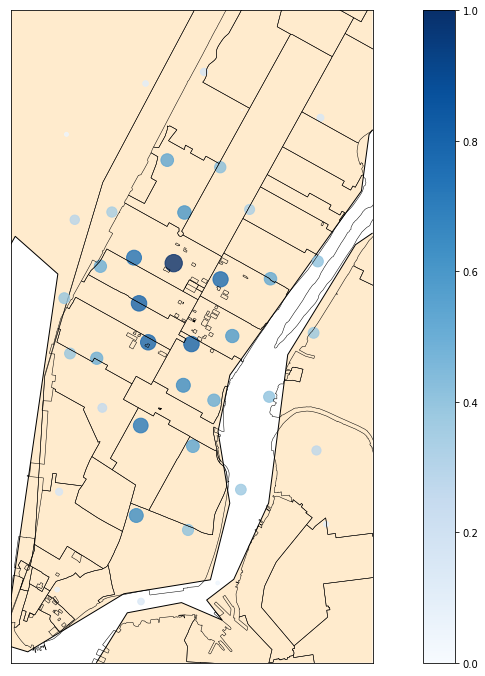

In [80]:
t1_map = draw_graph_colors(t1, shapefiles=shapefiles, draw_edges=False)

FINISHED PROJ. COORDINATES...STARTING NODES


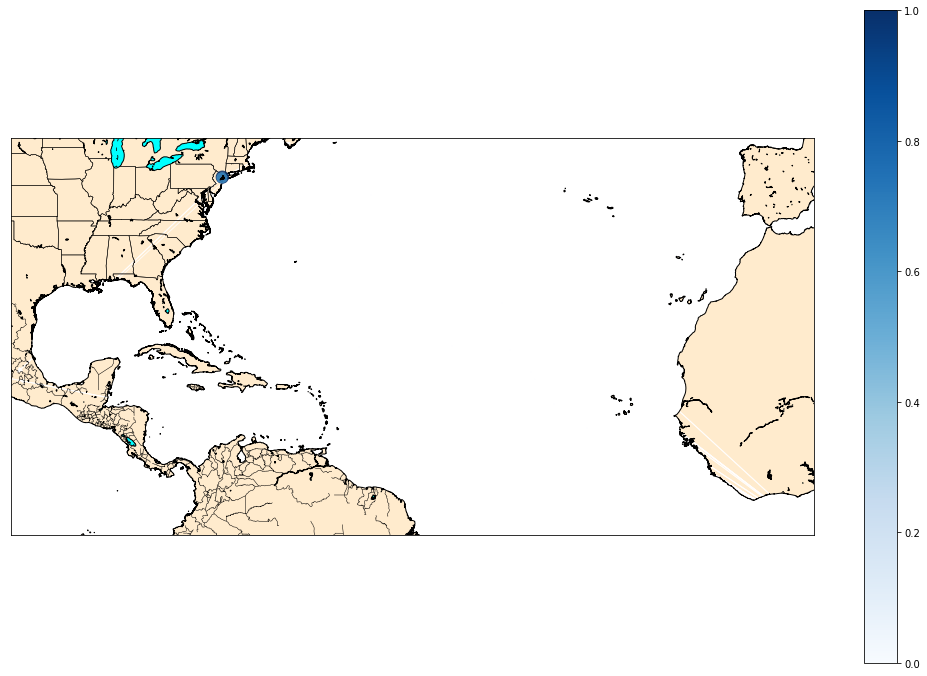

In [71]:
man_coords = [40.6664, 40.8851, -74.0587, -73.8890]
t1_map_raw = draw_graph_colors(t1_raw, shapefiles=shapefiles)

okay lessons learned - we NEED to remove outliers from taxi data or else we will get...the map of the USA. And we need to compare the weights of taxi AND uber data together from the SAME time period to gather any meaningful conclusions. Leggo

## Comparing taxi and uber

In [16]:
# gather uber data
data_uber = pd.read_csv("uber-trip-data/uber-raw-data-apr14.csv")

In [59]:
u1 = nx.read_graphml('graphs/k_all_uber.graphml')
t1 = nx.read_graphml('graphs/kall-taxi-clean.graphml')

In [18]:
def get_weighted_nodes2(G1, G2, ref):
    # get weights into the range [0.5-1]
    out_raw1 = dict(G1.out_degree(weight='weight'))
    out_raw2 = dict(G2.out_degree(weight='weight'))
    min_out = min(min(out_raw1.values()), min(out_raw2.values()))
    max_out = max(max(out_raw1.values()), max(out_raw2.values()))
    out_weights1 = {k:(v-min_out)/(max_out-min_out) for (k,v) in out_raw1.items()}
    out_weights2 = {k:(v-min_out)/(max_out-min_out) for (k,v) in out_raw2.items()}
    
    # adjust sizing of nodes based on their relative out-degrees
    sizes = [[],[]]
    for node in list(G1.nodes()):
        sizes[0].append(ref*0.5*(out_weights1[node]) +  0.5*ref)
    for node in list(G2.nodes()):
        sizes[1].append(ref*0.5*(out_weights2[node]) + 0.5*ref)
    return sizes

In [17]:
def compare_graphs(G1, G2, coords=None, node_size=600, draw_edges=True):
    plt.figure(figsize=(16,8))
    if coords is None:
        coords = get_coords(G1) # orient map in terms of first graph
        
    # jess apologizes greatly for this crappy copy-paste code
    plt.subplot(1,2,1)
    m1 = Basemap(projection='merc',llcrnrlat=coords[0],urcrnrlat=coords[1],llcrnrlon=coords[2], urcrnrlon=coords[3], resolution='h')
    m1.drawcoastlines()
    m1.drawstates()
    m1.fillcontinents(color='blanchedalmond',lake_color='aqua')
    pos1 = get_pos(G1, m1)
    
    # create networkx graph 
    print("CALCULATING RELATIVE WEIGHTS\n")
    cmap = plt.cm.Blues
    c_weights = get_weighted_nodes2(G1, G2, 1.0)
    sz_weights = get_weighted_nodes2(G1, G2, node_size)
    print("FINISHED PROJ. COORDINATES...STARTING NODES FOR GRAPH 1\n")
    nx.draw_networkx_nodes(G = G1, pos = pos1, node_color = c_weights[0], alpha=0.8,
                           node_size=sz_weights[0], cmap=cmap)
    if draw_edges:
        nx.draw_networkx_edges(G = G1, pos = pos1, edge_color='white', alpha=0.8, arrows = True)
        
    for file, name in shapefiles.items():
        m1.readshapefile(file, name)
    
    # START MAP 2 STUFF
    plt.subplot(1,2,2)
    print("FINISHED PROJ. COORDINATES...STARTING NODES FOR GRAPH 2\n")
    m2 = Basemap(projection='merc',llcrnrlat=coords[0],urcrnrlat=coords[1],llcrnrlon=coords[2], urcrnrlon=coords[3], resolution='h')
    m2.drawcoastlines()
    m2.drawstates()
    m2.fillcontinents(color='blanchedalmond',lake_color='aqua')
    pos2 = get_pos(G2, m2)
    nx.draw_networkx_nodes(G = G2, pos = pos2, node_color = c_weights[1], alpha=0.8,
                           node_size=sz_weights[1], cmap=cmap)
    if draw_edges:
        nx.draw_networkx_edges(G = G1, pos = pos1, edge_color='white', alpha=0.8, arrows = True)
        nx.draw_networkx_edges(G = G2, pos = pos2, edge_color='black', alpha=0.8, arrows = True)
        
    # read in shapefiles to project on top of map 
    for file, name in shapefiles.items():
        m2.readshapefile(file, name)
        
    # set colorbar
    sm = plt.cm.ScalarMappable(cmap=cmap, norm=plt.Normalize(vmin=0, vmax=1))
    sm.set_array([])
    cbar = plt.colorbar(sm)

    plt.show()
    return [m1, m2]

CALCULATING RELATIVE WEIGHTS

FINISHED PROJ. COORDINATES...STARTING NODES FOR GRAPH 1

FINISHED PROJ. COORDINATES...STARTING NODES FOR GRAPH 2



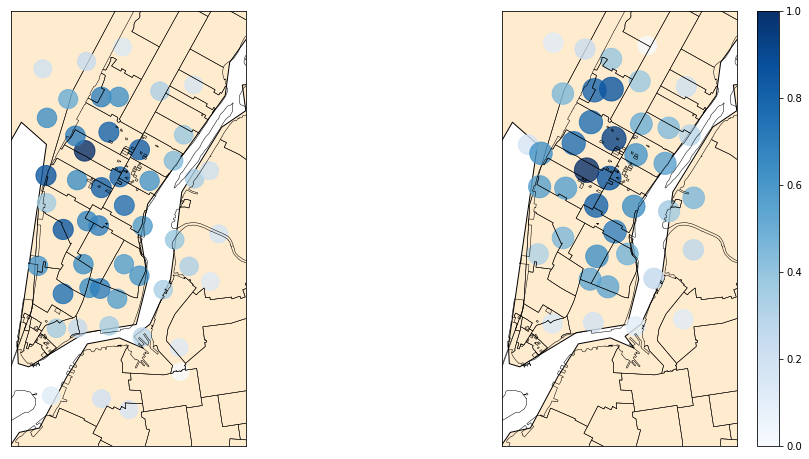

In [104]:
g12 = compare_graphs(u1,t1, draw_edges=False)

okay - so taking ~56000 trips from the month of april 2014, we can see that the left plot (uber) has slightly more clusters in the surrounding areas than right (taxi), and a more spread-out density of nodes
Now can we quantify this using networkx analysis? 

In [33]:
# determine the optimal k-value 
def plot_k2(coords1, coords2):
    K = range(20, 100, 5)
    inertia_1 = []
    inertia_2 = []
    km = KMeans()
    for k in K:
        km1 = KMeans(n_clusters=k)
        km2 = KMeans(n_clusters=k)
        k_model1 = km1.fit(coords1)
        k_model2 = km2.fit(coords2)
        inertia_1.append(k_model1.inertia_)
        inertia_2.append(k_model2.inertia_)
        
    plt.figure(figsize=(12,8))
    plt.plot(K, inertia_1, 'b-', K, inertia_2, 'r-')
    plt.legend('taxi', 'uber')
    plt.show()
    return [inertia_1, inertia_2]
    

/mnt/c/Users/jess2/Princeton/Junior/ELE381/proj/env/lib/python3.5/site-packages/matplotlib/legend.py:798: UserWarning: Legend does not support 't' instances.
A proxy artist may be used instead.
See: http://matplotlib.org/users/legend_guide.html#creating-artists-specifically-for-adding-to-the-legend-aka-proxy-artists
  "aka-proxy-artists".format(orig_handle)
/mnt/c/Users/jess2/Princeton/Junior/ELE381/proj/env/lib/python3.5/site-packages/matplotlib/legend.py:798: UserWarning: Legend does not support 'a' instances.
A proxy artist may be used instead.
See: http://matplotlib.org/users/legend_guide.html#creating-artists-specifically-for-adding-to-the-legend-aka-proxy-artists
  "aka-proxy-artists".format(orig_handle)
/mnt/c/Users/jess2/Princeton/Junior/ELE381/proj/env/lib/python3.5/site-packages/matplotlib/legend.py:798: UserWarning: Legend does not support 'x' instances.
A proxy artist may be used instead.
See: http://matplotlib.org/users/legend_guide.html#creating-artists-specifically-for-a

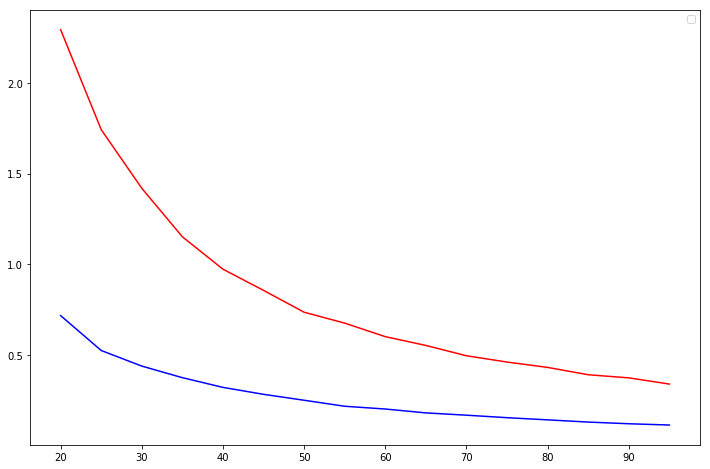

In [34]:
coords_t = np.array(list(zip(data_taxi['pickup_latitude'][1:10000], data_taxi['pickup_longitude'][1:10000])))
coords_u = np.array(list(zip(data_uber['Lat'][1:10000], data_uber['Lon'][1:10000])))
elbow_plot = plot_k2(coords_t, coords_u)

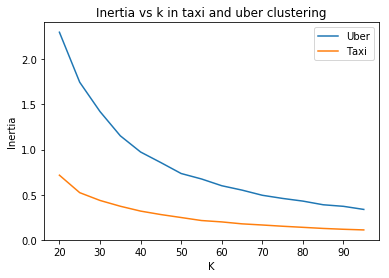

In [38]:
K = range(20, 100, 5)
# time to make this graph neater w/o recomputing everything lol 
ax=plt.figure()
plt.title("Inertia vs k in taxi and uber clustering")
plt.xlabel('K')
plt.ylabel('Inertia') # within-cluster sum of squares error 
plt.plot(K, elbow_plot[1], label='Uber')
plt.plot(K, elbow_plot[0], label='Taxi')
plt.legend(loc='upper right')

okay this shows that the inertia of uber is much higher, indicating a greater variability in its clustering!!!

In [60]:
pg_u = nx.pagerank(u1)
pg_t = nx.pagerank(t1)

In [61]:
y_u = list(pg_u.values())
y_u.sort(reverse=True)
y_t = list(pg_t.values())
y_t.sort(reverse=True)

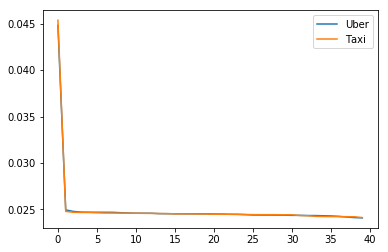

In [65]:
x = range(0,40)
plt.figure()
plt.plot(x,y_u, label='Uber')
plt.plot(x,y_t, label="Taxi")
plt.legend(loc='upper right')

pagerank shows that there is a similar concentration of one pick-up location in uber vs taxi despite the greater variability, showing that despite it reaching the outskirts of NYC, the majority of pick-ups are still in central manhattan 

In [79]:
rel_weights = get_weighted_nodes2(u1, t1, 1.0)

Text(0.5, 1.0, 'Relative weights of each cluster')

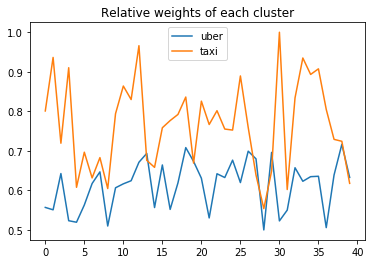

In [88]:
num_nodes = len(rel_weights[0])
plt.figure()
plt.plot(range(0,num_nodes), rel_weights[0], label='uber')
plt.plot(range(0,num_nodes), rel_weights[1], label='taxi')
plt.legend(loc='best')
plt.title("Relative weights of each cluster")

Unsure what this is showing, but I guess 1) taxi has an overall higher weight in  comparison per cluster??? .-. idk

## anyways let's try doing the before/after taxi comparisons now!

### additional verification using increased sample size

In [31]:
def create_graph_bymonth(month, datetime):
    client = Socrata("data.cityofnewyork.us", None)
    # rip modularity when the number of days in each month varies 
    results = client.get("gkne-dk5s", where=datetime, limit=1000000)
    data = pd.DataFrame.from_records(results)
    g = createDiGraphK_clean(data, k=16, name='taxi14_' + month)
    return g

In [16]:
# construct graphs
t14_bymonth = {}
u14_bymonth = {}
months = ['apr', 'may', 'jun', 'jul', 'aug', 'sep']
for i, month in enumerate(months):
    print("Creating graph for month " +  month)
    date = "pickup_datetime between '2014-0" + str(i+3) + "-01T00:00:00' and '2014-0" + str(i+3) + "-30T23:59:59'"
    t14_bymonth[month] = create_graph_bymonth(month, date)
    u14_bymonth[month] = nx.read_graphml('graphs/uber_' + month + '_14.graphml')

Creating graph for month apr


/mnt/c/Users/jess2/Princeton/Junior/ELE381/proj/env/lib/python3.5/site-packages/scipy/cluster/vq.py:580: UserWarning: One of the clusters is empty. Re-run kmeans with a different initialization.
  warnings.warn("One of the clusters is empty. "


Creating graph for month may


Creating graph for month jun


Creating graph for month jul


Creating graph for month aug


Creating graph for month sep


CALCULATING RELATIVE WEIGHTS

FINISHED PROJ. COORDINATES...STARTING NODES FOR GRAPH 1

FINISHED PROJ. COORDINATES...STARTING NODES FOR GRAPH 2



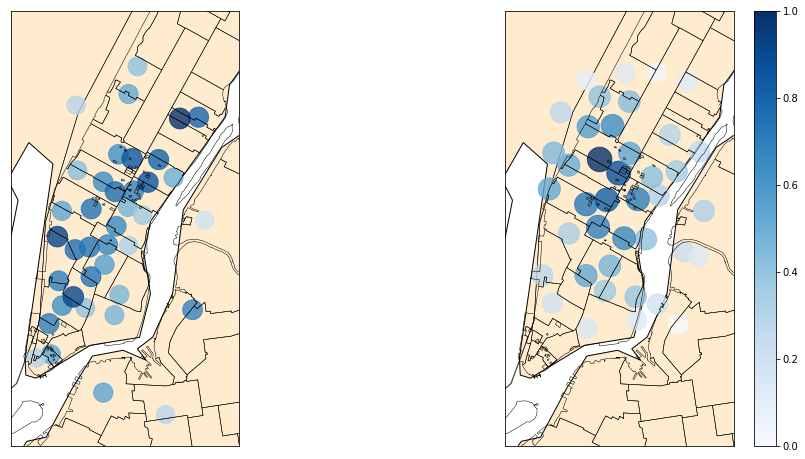

CALCULATING RELATIVE WEIGHTS

FINISHED PROJ. COORDINATES...STARTING NODES FOR GRAPH 1

FINISHED PROJ. COORDINATES...STARTING NODES FOR GRAPH 2



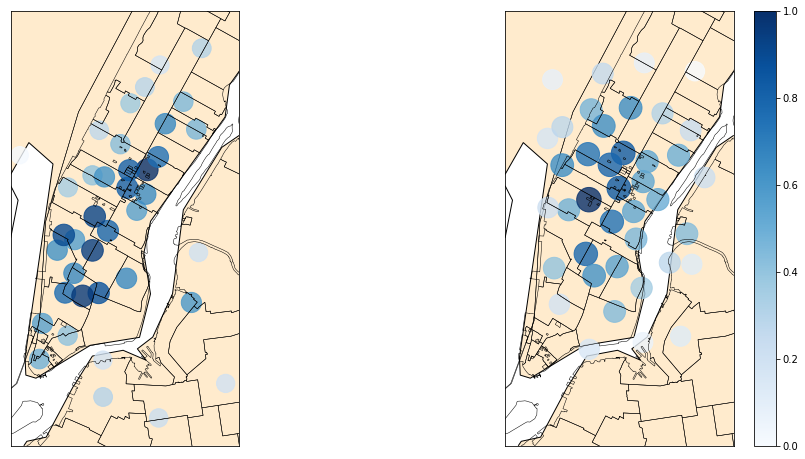

CALCULATING RELATIVE WEIGHTS

FINISHED PROJ. COORDINATES...STARTING NODES FOR GRAPH 1

FINISHED PROJ. COORDINATES...STARTING NODES FOR GRAPH 2



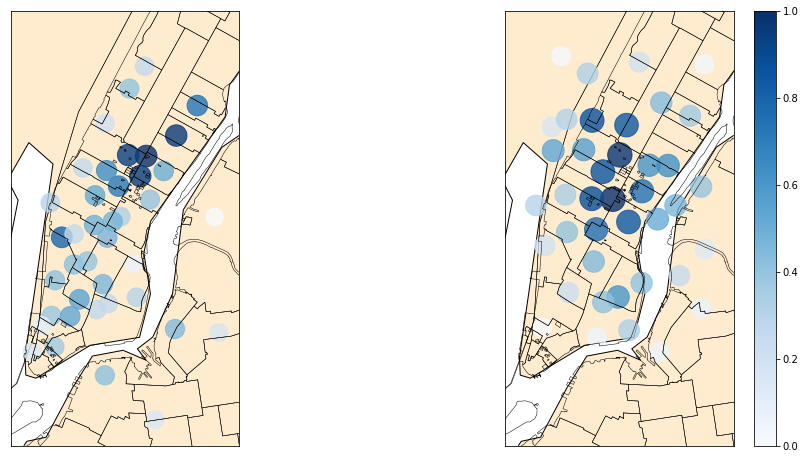

CALCULATING RELATIVE WEIGHTS

FINISHED PROJ. COORDINATES...STARTING NODES FOR GRAPH 1

FINISHED PROJ. COORDINATES...STARTING NODES FOR GRAPH 2



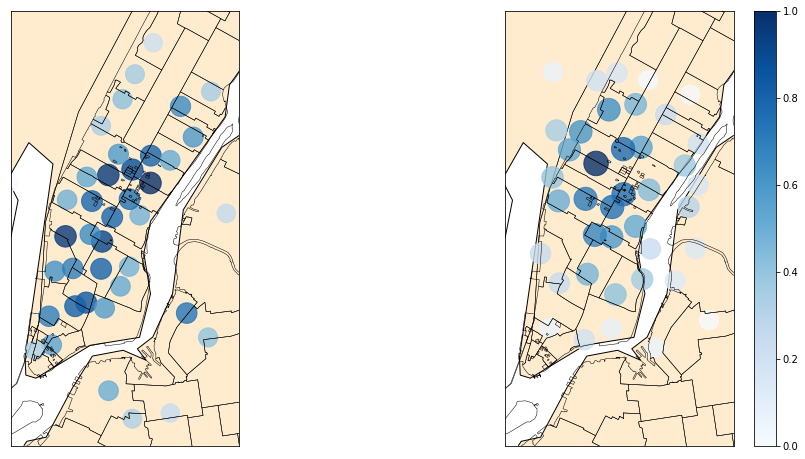

CALCULATING RELATIVE WEIGHTS

FINISHED PROJ. COORDINATES...STARTING NODES FOR GRAPH 1

FINISHED PROJ. COORDINATES...STARTING NODES FOR GRAPH 2



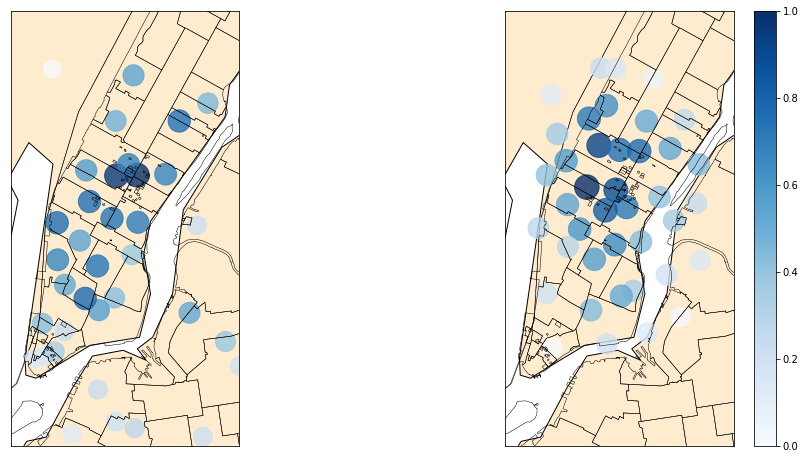

CALCULATING RELATIVE WEIGHTS

FINISHED PROJ. COORDINATES...STARTING NODES FOR GRAPH 1

FINISHED PROJ. COORDINATES...STARTING NODES FOR GRAPH 2



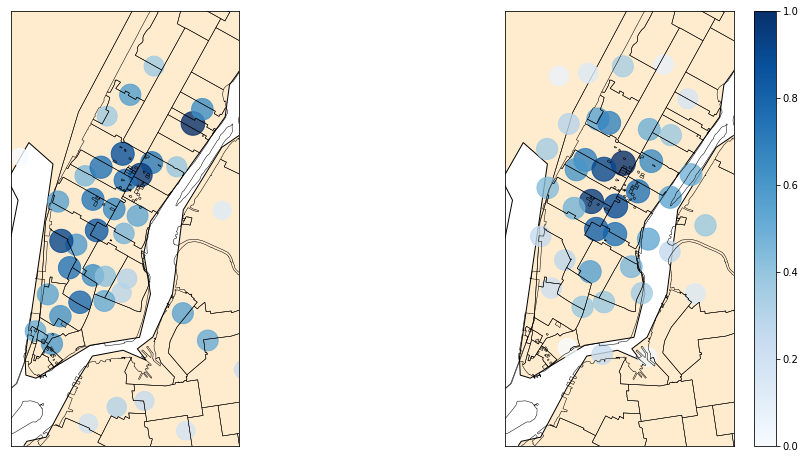

In [29]:
shapefiles = {}
shapefiles['shapes/ZIP_CODE_N'] = 'zipcodes'
man_coords = [40.68040258439974, 40.8054502842183, -74.02433118610789, -73.93755946089878]
for month in months: 
    compare_graphs(u14_bymonth[month], t14_bymonth[month], coords=man_coords, draw_edges=False)

So here we see the results of all 6 months which confirms our original findings - Uber has more reach into lower Manhattan, Midtown and Queens, whereas taxi is consistently more centered around midtown (disregard NJ data) 

Now checking the 2015 data...JK the uber 2015 dataset zip seems corrupted. 